In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pqcd.utils import (
    rcparams,
    to_GeV_per_cubic_femtometre,
    to_nucleons_per_cubic_femtometre,
    nsat
)
plt.rcParams.update(rcparams)

In [2]:
collated_eos_path = [
    '../data/eos-draws-default.csv',
    '../data/collated_np_all_post.csv', 
    '/home/isaac.legred/PTAnalysis/Analysis/collated_np_all_post.csv'
    ][0]

In [3]:
# Load the collated EOSs
collated_eos = pd.read_csv(collated_eos_path)

# The pre-computed weights of these EOSs
astro_weights = np.exp(collated_eos.logweight_total.values)

In [4]:
collated_ntov = to_nucleons_per_cubic_femtometre(collated_eos['rhoc(M@Mmax)'])

23732


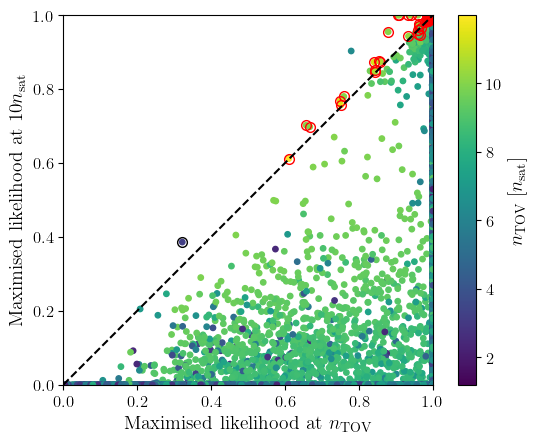

In [5]:
# pQCD likelihood scatter (Xmarg)

nterm_xy = ['ntov', '10nsat']
method = 'Xmarg'

# Remove large nTOV outliers for clarity
plot_mask = collated_ntov < 30*nsat

likelihood_x = np.loadtxt(f'../data/weights/qcd_weights_{nterm_xy[0]}_{method}.dat')[plot_mask]
likelihood_y = np.loadtxt(f'../data/weights/qcd_weights_{nterm_xy[1]}_{method}.dat')[plot_mask]

fig, ax = plt.subplots()
ax.set_aspect('equal')

im = ax.scatter(
    likelihood_x, 
    likelihood_y, 
    c=collated_ntov[plot_mask]/nsat, 
    cmap='viridis',
    s=15
    )

# Highlight EOSs that have nTOV > 10nsat
for ntov, x, y in zip(collated_ntov[plot_mask], likelihood_x, likelihood_y):
    if ntov > 10*nsat:
        ax.plot(x, y, marker='o', markersize=7, markerfacecolor='none', markeredgecolor='r')

# Identify outliers
for i, (ntov, x, y) in enumerate(zip(collated_ntov[plot_mask], likelihood_x, likelihood_y)):
    if (ntov < 5*nsat) & (y > x):
        ax.plot(x, y, marker='o', markersize=7, markerfacecolor='none', markeredgecolor='k')
        print(i)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$n_\mathrm{TOV}$ [$n_\mathrm{sat}$]')

ax.set_xlabel('Maximised likelihood at $n_\mathrm{TOV}$')
ax.set_ylabel('Maximised likelihood at $10n_\mathrm{sat}$')

ax.plot([0, 1], [0, 1], 'k--')

ax.set_xlim(0, 1) # , 1)
ax.set_ylim(0, 1) # , 0.5)

fig.savefig(f'figures/likelihood/likelihood_scatter_{nterm_xy[0]}_{nterm_xy[1]}_{method}.pdf')

(0.9, 1.0)

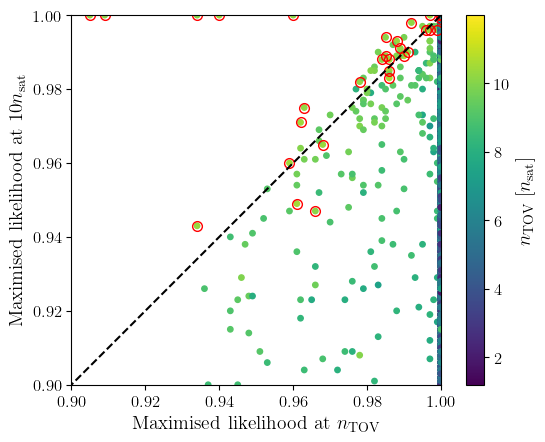

In [6]:
# pQCD likelihood scatter (Xmarg) (Zoomed)

nterm_xy = ['ntov', '10nsat']
method = 'Xmarg'

# Remove large nTOV outliers for clarity
plot_mask = collated_ntov < 30*nsat

likelihood_x = np.loadtxt(f'../data/weights/qcd_weights_{nterm_xy[0]}_{method}.dat')[plot_mask]
likelihood_y = np.loadtxt(f'../data/weights/qcd_weights_{nterm_xy[1]}_{method}.dat')[plot_mask]

fig, ax = plt.subplots()
ax.set_aspect('equal')

im = ax.scatter(
    likelihood_x, 
    likelihood_y, 
    c=collated_ntov[plot_mask]/nsat, 
    cmap='viridis',
    s=15
    )

for ntov, x, y in zip(collated_ntov[plot_mask], likelihood_x, likelihood_y):
    if ntov > 10*nsat:
        ax.plot(x, y, marker='o', markersize=7, markerfacecolor='none', markeredgecolor='r')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$n_\mathrm{TOV}$ [$n_\mathrm{sat}$]')

ax.set_xlabel('Maximised likelihood at $n_\mathrm{TOV}$')
ax.set_ylabel('Maximised likelihood at $10n_\mathrm{sat}$')

ax.plot([0, 1], [0, 1], 'k--')

ax.set_xlim(0.9, 1) # , 1)
ax.set_ylim(0.9, 1) # , 0.5)

In [7]:
# Some example (mu [GeV], n [1/fm^3], p [GeV/fm^3]) values

chiEFT_values = {
    'soft': [0.966, 0.176, 2.163/1000],
    'stiff': [0.978, 0.176, 3.542/1000]
}

# Keys are different values for the renormalization scale parameter X
pQCD_values = {
    1: [2.6, 6.14, 2334/1000],
    2: [2.6, 6.47, 3823/1000],
    4: [2.6, 6.87, 4284/1000]
}

muL, nL, pL = chiEFT_values['stiff']
muH, nH, pH = pQCD_values[2]

In [8]:
# This EOS has a higher likelihood at 10nsat than at nTOV, despite nTOV being 
# lower
eos_index = 23732
eos = collated_eos[plot_mask].iloc[eos_index]
eos_ntov = to_nucleons_per_cubic_femtometre(eos['rhoc(M@Mmax)'])

print(eos_ntov/nsat)

3.2156415948680404


In [9]:
energy_density_at_ntov = np.loadtxt('../data/quantities_at_ntov/energy_density.dat')[plot_mask][eos_index]
pressure_at_ntov = np.loadtxt('../data/quantities_at_ntov/pressure.dat')[plot_mask][eos_index]

energy_density_at_10nsat = np.loadtxt('../data/quantities_at_fixed_n/energy_density_10nsat.dat')[plot_mask][eos_index]
pressure_at_10nsat = np.loadtxt('../data/quantities_at_fixed_n/pressure_10nsat.dat')[plot_mask][eos_index]

chemical_potential_at_ntov = (energy_density_at_ntov + pressure_at_ntov)/eos_ntov
chemical_potential_at_10nsat = (energy_density_at_10nsat + pressure_at_10nsat)/(10*nsat)

In [10]:
# First lets re-compute the likelihood

from pqcd.likelihood import maximised_likelihood

def maximised_likelihood_Xmarg(e, p, n, N=1000):

    weight = np.zeros(N)

    for i in range(N):
        
        logX = np.random.uniform(np.log(1/2), np.log(2))
        
        # For each X assign 0 or 1 for given point
        weight[i] = int(maximised_likelihood(e0=e, p0=p, n0=n, X=np.exp(logX)))

    return weight.mean()

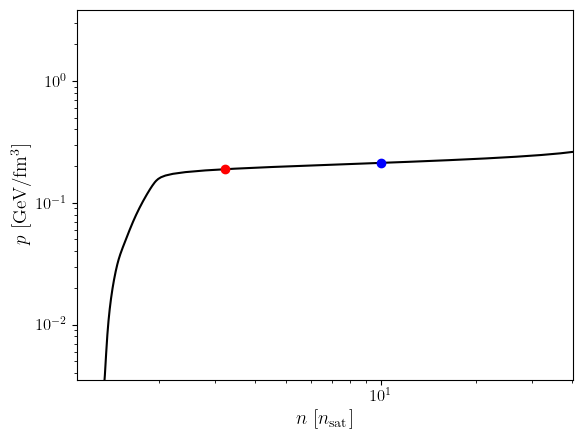

In [11]:
# Load the EOS
df = pd.read_csv(f'../data/eos-draws-default/eos-draw-{int(eos.eos):06}.csv')

pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)
chemical_potential = (energy_density+pressure)/number_density

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(number_density/nsat, pressure, c='k')
ax.plot(eos_ntov/nsat, pressure_at_ntov, 'ro')
ax.plot(10, pressure_at_10nsat, 'bo')

ax.set_xlim(nL/nsat, nH/nsat)
ax.set_ylim(pL, pH)

ax.set_xlabel(r'$n\ [n_\mathrm{sat}]$')
_ = ax.set_ylabel(r'$p$ [GeV/fm$^3$]')

In [12]:
repeats = 1000

likelihoods_at_ntov = []
likelihoods_at_10nsat = []
for _ in range(repeats):
    likelihoods_at_ntov.append(maximised_likelihood_Xmarg(energy_density_at_ntov, pressure_at_ntov, eos_ntov))
    likelihoods_at_10nsat.append(maximised_likelihood_Xmarg(energy_density_at_10nsat, pressure_at_10nsat, 10*nsat))

(0.0, 1.0)

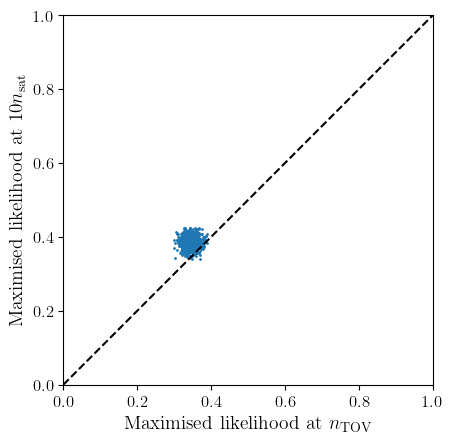

In [13]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

im = ax.scatter(
    likelihoods_at_ntov, 
    likelihoods_at_10nsat, 
    s=1
    )

ax.set_xlabel('Maximised likelihood at $n_\mathrm{TOV}$')
ax.set_ylabel('Maximised likelihood at $10n_\mathrm{sat}$')

ax.plot([0, 1], [0, 1], 'k--')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

So maybe this is fine because of the spread?

We can re-do the above plot, but share the $X$ value used at each density...

23732


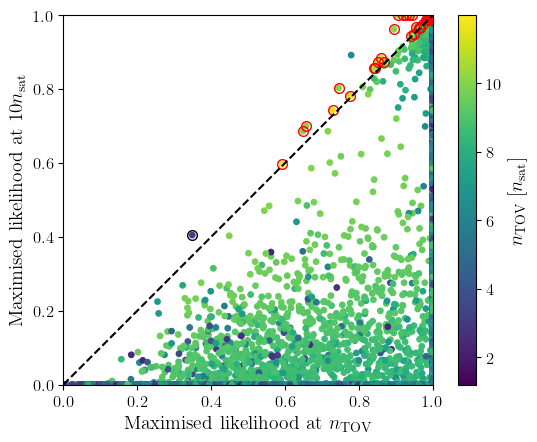

In [14]:
# pQCD likelihood scatter (Xmarg)

nterm_xy = ['ntov', '10nsat']
method = 'Xmarg_shared'

# Remove large nTOV outliers for clarity
plot_mask = collated_ntov < 30*nsat

likelihood_x = np.loadtxt(f'../data/weights_Xmarg_shared/qcd_weights_{nterm_xy[0]}_{method}.dat')[plot_mask]
likelihood_y = np.loadtxt(f'../data/weights_Xmarg_shared/qcd_weights_{nterm_xy[1]}_{method}.dat')[plot_mask]

fig, ax = plt.subplots()
ax.set_aspect('equal')

im = ax.scatter(
    likelihood_x, 
    likelihood_y, 
    c=collated_ntov[plot_mask]/nsat, 
    cmap='viridis',
    s=15
    )

# Highlight EOSs that have nTOV > 10nsat
for ntov, x, y in zip(collated_ntov[plot_mask], likelihood_x, likelihood_y):
    if ntov > 10*nsat:
        ax.plot(x, y, marker='o', markersize=7, markerfacecolor='none', markeredgecolor='r')

# Identify outliers
for i, (ntov, x, y) in enumerate(zip(collated_ntov[plot_mask], likelihood_x, likelihood_y)):
    if (ntov < 5*nsat) & (y > x):
        ax.plot(x, y, marker='o', markersize=7, markerfacecolor='none', markeredgecolor='k')
        print(i)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$n_\mathrm{TOV}$ [$n_\mathrm{sat}$]')

ax.set_xlabel('Maximised likelihood at $n_\mathrm{TOV}$')
ax.set_ylabel('Maximised likelihood at $10n_\mathrm{sat}$')

ax.plot([0, 1], [0, 1], 'k--')

ax.set_xlim(0, 1) # , 1)
ax.set_ylim(0, 1) # , 0.5)

fig.savefig(f'figures/likelihood/likelihood_scatter_{nterm_xy[0]}_{nterm_xy[1]}_{method}.pdf', bbox_inches='tight')

23732


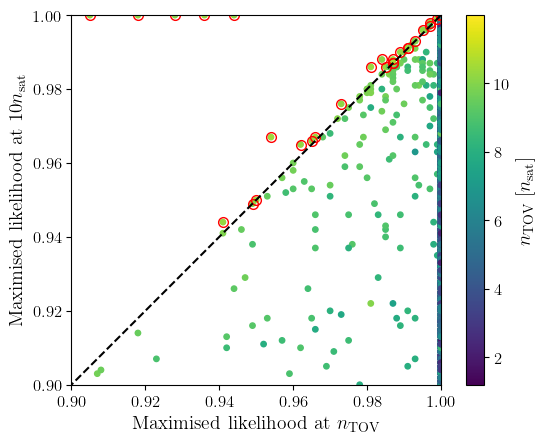

In [15]:
# pQCD likelihood scatter (Xmarg)

nterm_xy = ['ntov', '10nsat']
method = 'Xmarg_shared'

# Remove large nTOV outliers for clarity
plot_mask = collated_ntov < 30*nsat

likelihood_x = np.loadtxt(f'../data/weights_Xmarg_shared/qcd_weights_{nterm_xy[0]}_{method}.dat')[plot_mask]
likelihood_y = np.loadtxt(f'../data/weights_Xmarg_shared/qcd_weights_{nterm_xy[1]}_{method}.dat')[plot_mask]

fig, ax = plt.subplots()
ax.set_aspect('equal')

im = ax.scatter(
    likelihood_x, 
    likelihood_y, 
    c=collated_ntov[plot_mask]/nsat, 
    cmap='viridis',
    s=15
    )

# Highlight EOSs that have nTOV > 10nsat
for ntov, x, y in zip(collated_ntov[plot_mask], likelihood_x, likelihood_y):
    if ntov > 10*nsat:
        ax.plot(x, y, marker='o', markersize=7, markerfacecolor='none', markeredgecolor='r')

# Identify outliers
for i, (ntov, x, y) in enumerate(zip(collated_ntov[plot_mask], likelihood_x, likelihood_y)):
    if (ntov < 5*nsat) & (y > x):
        ax.plot(x, y, marker='o', markersize=7, markerfacecolor='none', markeredgecolor='k')
        print(i)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$n_\mathrm{TOV}$ [$n_\mathrm{sat}$]')

ax.set_xlabel('Maximised likelihood at $n_\mathrm{TOV}$')
ax.set_ylabel('Maximised likelihood at $10n_\mathrm{sat}$')

ax.plot([0, 1], [0, 1], 'k--')

ax.set_xlim(0.9, 1)
_ = ax.set_ylim(0.9, 1)

This looks a bit cleaner, but the outlier highlighted in black still remains... is there spread in the likelihoods even when sharing the $X$ value across densities?

In [16]:
def maximised_likelihood_Xmarg_shared(e_list, p_list, n_list, N=1000):
    """
    A modified qcd_likelihood function that, for a given random X sample, 
    computes the likelihood at a list of densities.
    """
    weights = np.zeros(len(n_list))

    for _ in range(N):
        
        logX = np.random.uniform(np.log(1/2), np.log(2))
        
        for i, (e, p, n) in enumerate(zip(e_list, p_list, n_list)):
            if np.isnan(p) or np.isnan(e):
                weights[i] += 0
            else:
                weights[i] += int(maximised_likelihood(e0=e,p0=p,n0=n,X=np.exp(logX)))

    return weights/N

In [17]:
repeats = 1000

likelihoods_shared = []
for _ in range(repeats):
    likelihoods_shared.append(maximised_likelihood_Xmarg_shared(
        [energy_density_at_ntov, energy_density_at_10nsat], 
        [pressure_at_ntov, pressure_at_10nsat], 
        [eos_ntov, 10*nsat]
        ))

likelihoods_shared = np.array(likelihoods_shared)

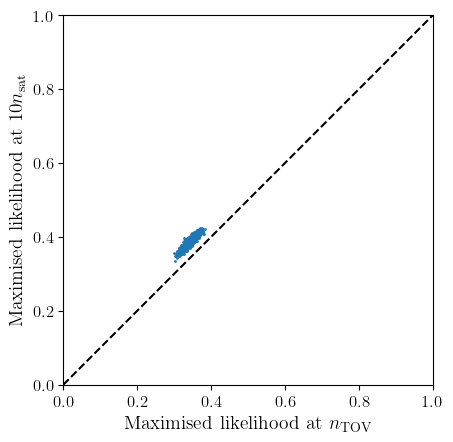

In [18]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

im = ax.scatter(
    likelihoods_shared[:,0], 
    likelihoods_shared[:,1], 
    s=1
    )

ax.set_xlabel('Maximised likelihood at $n_\mathrm{TOV}$')
ax.set_ylabel('Maximised likelihood at $10n_\mathrm{sat}$')

ax.plot([0, 1], [0, 1], 'k--')

ax.set_xlim(0, 1)
_ = ax.set_ylim(0, 1)

Does this mean there are values of $X$ for which the EOS is allowed at $10n_\mathrm{sat}$ but not at $n_\mathrm{TOV}$?

In [19]:
X_list = np.linspace(1/2, 2, num=1000)

likelihoods_at_10nsat = np.zeros_like(X_list)
likelihoods_at_ntov = np.zeros_like(X_list)

for i, X in enumerate(X_list):
    likelihoods_at_ntov[i] = maximised_likelihood(e0=energy_density_at_ntov, p0=pressure_at_ntov, n0=eos_ntov, X=X)
    likelihoods_at_10nsat[i] = maximised_likelihood(e0=energy_density_at_10nsat, p0=pressure_at_10nsat, n0=10*nsat, X=X)

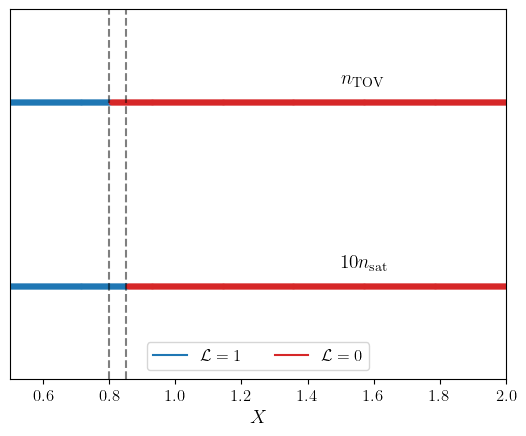

In [20]:
fig, ax = plt.subplots()

for l, X in zip(likelihoods_at_ntov, X_list):
    c = 'C0' if l else 'C3'
    ax.plot(X, 1, c=c, marker='.')

for l, X in zip(likelihoods_at_10nsat, X_list):
    c = 'C0' if l else 'C3'
    ax.plot(X, 0, c=c, marker='.')

handles = [
    plt.Line2D([0], [0], c='C0', label='$\mathcal{L} = 1$'),
    plt.Line2D([0], [0], c='C3', label='$\mathcal{L} = 0$')]
ax.legend(handles=handles, loc='lower center', ncols=2)

ax.set_xlabel(r'$X$')

ax.set_xlim(0.5, 2)
ax.set_ylim(-0.5, 1.5)

ax.text(1.5, 1.1, r'$n_\mathrm{TOV}$', color='k')
ax.text(1.5, 0.1, r'$10n_\mathrm{sat}$', color='k')

ax.axvline(0.8, c='k', ls='--', alpha=0.5)
ax.axvline(0.85, c='k', ls='--', alpha=0.5)

_ = ax.set_yticks([])

So there are some values of $X$ for which the EOS is allowed at $10n_\mathrm{sat}$ but not at $n_\mathrm{TOV}$. I'm pretty sure this makes no sense.

In [21]:
import pqcd

(0.0, 3.7141101772581773)

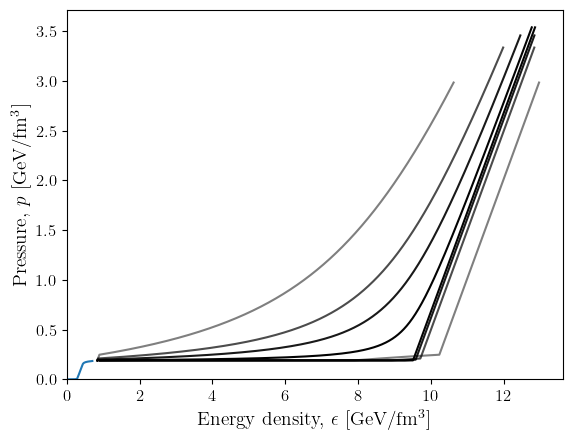

In [22]:
fig, ax = plt.subplots()

nterm = eos_ntov
end_index = np.argmin(np.abs(number_density - nterm))

X_list = [0.6, 0.7, 0.75, 0.79]
alpha_list = [0.5, 0.7, 0.9, 0.99]
muH = 2.6

for X, alpha in zip(X_list, alpha_list):

    constraints = pqcd.constraints(
        chemical_potential_at_ntov, 
        eos_ntov, 
        pressure_at_ntov, 
        muH, 
        X
    )
    mu_array = np.linspace(chemical_potential[end_index], muH, 1000)

    ax.plot(
        constraints.epsilon_min(mu_array), 
        constraints.pmax(mu_array, constraints.nmin(mu_array)), 
        c='k',
        alpha=alpha
        )
    ax.plot(
        np.concatenate(([energy_density[end_index]], constraints.epsilon_max(mu_array))), 
        np.concatenate(([pressure[end_index]], constraints.pmin(mu_array))), 
        c='k',
        alpha=alpha
        )

ax.plot(
    energy_density[:end_index], 
    pressure[:end_index], 
    alpha=1, 
    c='C0',
    zorder=0.1
    )

# ---

ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')
ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

ax.set_xlim(0) # , new_constraints.epsilonH+1)
ax.set_ylim(0) # , new_constraints.pH+1)

So as expected, from $n_\mathrm{TOV}$ the EOS has to follow a very particular behaviour when $X$ approaches 0.8. 

(0.0, 3.7141101772581773)

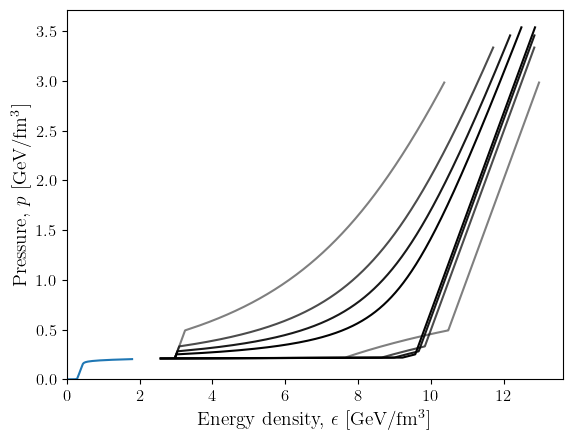

In [23]:
fig, ax = plt.subplots()

nterm = 10*nsat
end_index = np.argmin(np.abs(number_density - nterm))

X_list = [0.6, 0.7, 0.75, 0.79]
alpha_list = [0.5, 0.7, 0.9, 0.99]
muH = 2.6

for X, alpha in zip(X_list, alpha_list):

    constraints = pqcd.constraints(
        chemical_potential_at_10nsat, 
        10*nsat, 
        pressure_at_10nsat, 
        muH, 
        X
    )
    mu_array = np.linspace(chemical_potential[end_index], muH, 1000)

    ax.plot(
        constraints.epsilon_min(mu_array), 
        constraints.pmax(mu_array, constraints.nmin(mu_array)), 
        c='k',
        alpha=alpha
        )
    ax.plot(
        np.concatenate(([energy_density[end_index]], constraints.epsilon_max(mu_array))), 
        np.concatenate(([pressure[end_index]], constraints.pmin(mu_array))), 
        c='k',
        alpha=alpha
        )

ax.plot(
    energy_density[:end_index], 
    pressure[:end_index], 
    alpha=1, 
    c='C0',
    zorder=0.1
    )

# ---

ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')
ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

ax.set_xlim(0) # , new_constraints.epsilonH+1)
ax.set_ylim(0) # , new_constraints.pH+1)

But at $10n_\mathrm{sat}$, the EOS doesn't have to follow as strict a path as $X$ approaches 0.8. I guess this suggests that our EOS doesn't follow the expected path?

Text(0, 0.5, 'Pressure, $p$ [GeV/fm$^3$]')

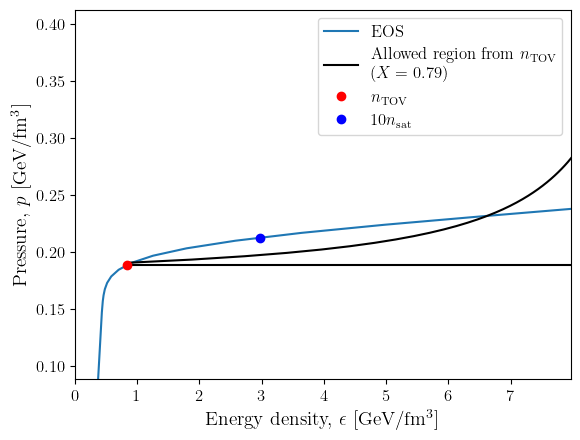

In [24]:
X = 0.79
muH = 2.6

constraints_at_ntov = pqcd.constraints(
    chemical_potential_at_ntov, 
    eos_ntov, 
    pressure_at_ntov, 
    muH, 
    X
)

mu_array = np.linspace(chemical_potential_at_ntov, muH, 1000)

fig, ax = plt.subplots()

ax.plot(energy_density, pressure, c='C0', label='EOS')

ax.plot(
    constraints_at_ntov.epsilon_min(mu_array), 
    constraints_at_ntov.pmax(mu_array, constraints_at_ntov.nmin(mu_array)), 
    c='k', label='Allowed region from $n_\mathrm{TOV}$\n$(X=0.79)$',
    )
ax.plot(
    np.concatenate(([energy_density_at_ntov], constraints_at_ntov.epsilon_max(mu_array))), 
    np.concatenate(([pressure_at_ntov], constraints_at_ntov.pmin(mu_array))), 
    c='k',
    )

ax.plot(energy_density_at_ntov, pressure_at_ntov, 'ro', label=r'$n_\mathrm{TOV}$')
ax.plot(energy_density_at_10nsat, pressure_at_10nsat, 'bo', label=r'$10n_\mathrm{sat}$')

ax.legend()

ax.set_xlim(0, energy_density_at_10nsat+5)
ax.set_ylim(pressure_at_ntov-0.1, pressure_at_10nsat+0.2)

ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')
ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

Text(0, 0.5, 'Density, $n$ [$n_\\mathrm{sat}$]')

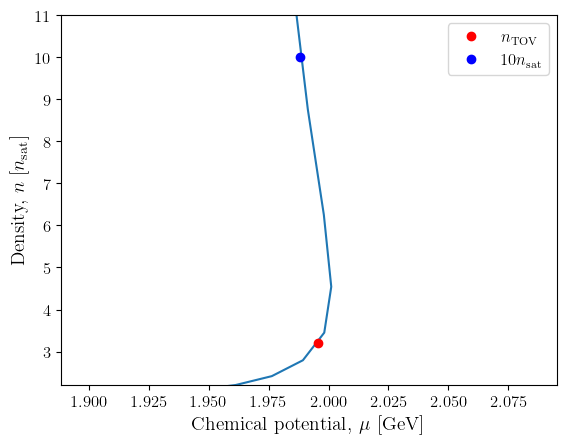

In [25]:
fig, ax = plt.subplots()

ax.plot(chemical_potential, number_density/nsat, c='C0')

# ax.plot(
#     constraints_at_ntov.epsilon_min(mu_array), 
#     constraints_at_ntov.pmax(mu_array, constraints_at_ntov.nmin(mu_array)), 
#     c='k',
#     )
# ax.plot(
#     np.concatenate(([energy_density_at_ntov], constraints_at_ntov.epsilon_max(mu_array))), 
#     np.concatenate(([pressure_at_ntov], constraints_at_ntov.pmin(mu_array))), 
#     c='k',
#     )

ax.plot(chemical_potential_at_ntov, eos_ntov/nsat, 'ro', label=r'$n_\mathrm{TOV}$')
ax.plot(chemical_potential_at_10nsat, 10, 'bo', label=r'$10n_\mathrm{sat}$')

# ax.plot(mu_array, constraints_at_ntov.nmin(mu_array)/nsat, c='k')
# ax.plot(mu_array, constraints_at_ntov.nmax(mu_array)/nsat, c='k')

ax.legend()

ax.set_xlim(chemical_potential_at_10nsat-0.1, chemical_potential_at_ntov+0.1)
ax.set_ylim(eos_ntov/nsat-1,10+1)

ax.set_xlabel(r'Chemical potential, $\mu$ [GeV]')
ax.set_ylabel(r'Density, $n$ [$n_\mathrm{sat}$]')

What happens here? Not causal? Maybe not stable?